## Install & Import Libraries and Functions

In [1]:
! pip install prophet
! pip install yfinance==0.1.44
! pip install pystan==2.19.1.1 prophet plotly

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# %matplotlib inline
import plotly

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, make_scorer
#mean_absolute_percentage_error
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import cross_val_score
from prophet import Prophet

import scipy
import yfinance as yf
import time
import datetime

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller

  Using cached prophet-1.0.1-py3-none-any.whl
  Using cached cmdstanpy-0.9.68-py3-none-any.whl (49 kB)
  Using cached ujson-5.1.0-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (44 kB)
  Attempting uninstall: cmdstanpy
    Found existing installation: cmdstanpy 0.9.5
    Uninstalling cmdstanpy-0.9.5:
      Successfully uninstalled cmdstanpy-0.9.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
fbprophet 0.7.1 requires cmdstanpy==0.9.5, but you have cmdstanpy 0.9.68 which is incompatible.
  Using cached yfinance-0.1.44-py3-none-any.whl
  Using cached multitasking-0.0.10-py3-none-any.whl
  Using cached plotly-5.5.0-py2.py3-none-any.whl (26.5 MB)
  Using cached tenacity-8.0.1-py3-none-any.whl (24 kB)


In [2]:
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)
pd.options.display.float_format = '{:,.2f}'.format
plt.rcParams.update({'font.size': 10})

## Read Data (Y-finance & LS)


In [3]:
# Update Today Date
Today=datetime.datetime.now()

In [4]:
#Download from Yahoo finance
ticker="CT=F"
period1=int(time.mktime(datetime.datetime(2000,3,1,23,59).timetuple()))
period2=int(time.mktime(Today.timetuple())) # To update with latest date
# period2=int(time.mktime(datetime.datetime(2023,12,30,23,59).timetuple()))
interval='1d' #1wk,1m

query_string=f'https://query1.finance.yahoo.com/v7/finance/download/{ticker}?period1={period1}&period2={period2}&interval={interval}&events=history&includeAdjustedClose=true'

dfy=pd.read_csv(query_string,parse_dates=['Date'],index_col="Date")

In [5]:
#Download from Yahoo finance
ticker_o="CL=F"
interval='1d' #1wk,1m

query_string_o=f'https://query1.finance.yahoo.com/v7/finance/download/{ticker_o}?period1={period1}&period2={period2}&interval={interval}&events=history&includeAdjustedClose=true'

dfy_o=pd.read_csv(query_string_o,parse_dates=['Date'],index_col="Date")

In [6]:
print(query_string)

https://query1.finance.yahoo.com/v7/finance/download/CT=F?period1=951955140&period2=1644332903&interval=1d&events=history&includeAdjustedClose=true


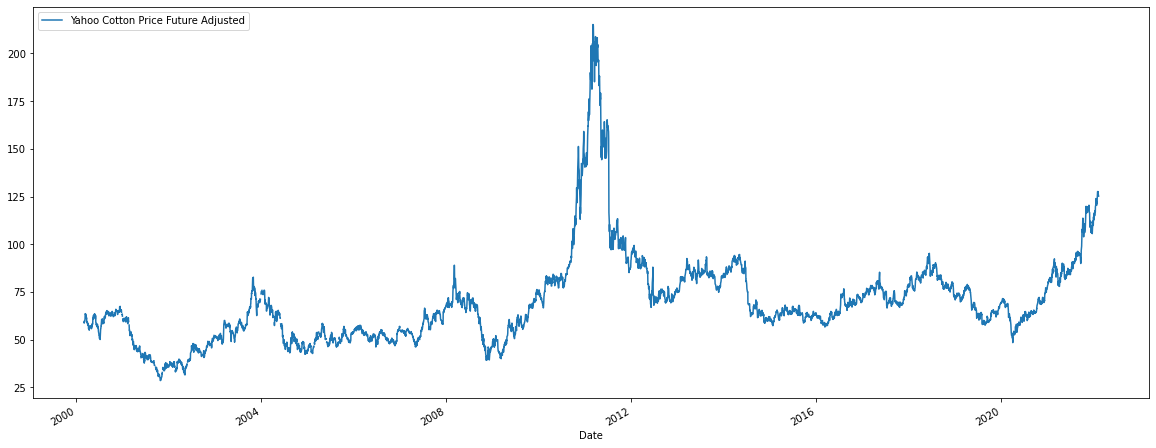

In [7]:
# Yahoo Finance CP data vs. LSE data
plt.clf()
dfy['Adj Close'].plot(label='Yahoo Cotton Price Future Adjusted', legend=True,figsize=(20,8))
# dfy_o['Adj Close'].plot(label='Yahoo Crude Oil Price Future Adjusted', legend=True,figsize=(20,8))
# dfy['Close'].plot(label='Yahoo Cotton Price Future', legend=True)
# dfy['Volume'].plot(label='Volume', secondary_y=True, legend=True)
plt.legend(loc=2)
plt.show()  # show the plot

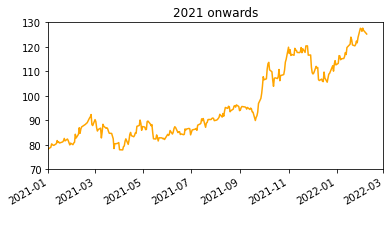

In [8]:
# 2021 onwards
plt.clf()
dfy['Adj Close'].plot(fontsize=10,color="orange",xlabel=" ",figsize=(6,3))
left1 = datetime.date(2021, 1, 1)
right1 = datetime.date(2022, 3, 1)
plt.gca().set_xbound(left1,right1)
plt.gca().set_ybound(70,130)
plt.title(fontsize=12,label="2021 onwards")
plt.show() 

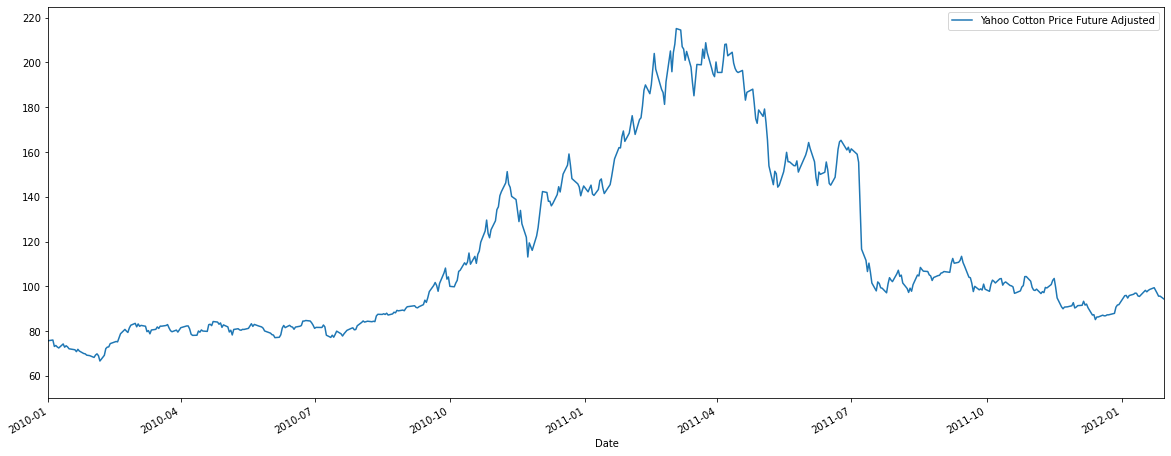

In [9]:
left = datetime.date(2010, 1, 1)
right = datetime.date(2012, 1, 30)

dfy['Adj Close'].plot(label='Yahoo Cotton Price Future Adjusted', legend=True,figsize=(20,8))

plt.gca().set_xbound(left,right)
plt.gca().set_ybound(50,225)

In [10]:
dfy.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5591 entries, 2000-03-01 to 2022-02-08
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       5501 non-null   float64
 1   High       5501 non-null   float64
 2   Low        5501 non-null   float64
 3   Close      5501 non-null   float64
 4   Adj Close  5501 non-null   float64
 5   Volume     5501 non-null   float64
dtypes: float64(6)
memory usage: 305.8 KB


In [11]:
dfy.tail(12)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2022-01-24,121.20,122.50,119.20,120.38,120.38,"17,635.00"
2022-01-25,120.40,121.44,120.05,120.92,120.92,"13,360.00"
2022-01-26,120.93,122.69,120.77,122.33,122.33,"12,474.00"
2022-01-27,121.92,122.14,120.85,121.63,121.63,"10,742.00"
2022-01-28,121.80,125.60,120.01,123.76,123.76,"22,800.00"
2022-01-31,123.76,127.71,123.25,127.57,127.57,"19,566.00"
2022-02-01,127.45,129.37,124.60,127.33,127.33,"25,488.00"
2022-02-02,127.46,128.45,125.87,126.33,126.33,"15,461.00"
2022-02-03,126.20,127.70,125.27,127.62,127.62,"18,190.00"


In [12]:
#drop null values
dfy=dfy.dropna()
dfy=dfy.drop_duplicates(subset=None, keep='first', inplace=False, ignore_index=False)

In [13]:
dfy.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5498 entries, 2000-03-01 to 2022-02-08
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       5498 non-null   float64
 1   High       5498 non-null   float64
 2   Low        5498 non-null   float64
 3   Close      5498 non-null   float64
 4   Adj Close  5498 non-null   float64
 5   Volume     5498 non-null   float64
dtypes: float64(6)
memory usage: 300.7 KB


In [14]:
dfy.describe()

,Open,High,Low,Close,Adj Close,Volume
count,"5,498.00","5,498.00","5,498.00","5,498.00","5,498.00","5,498.00"
mean,69.59,70.32,68.84,69.54,69.54,"7,727.10"
std,24.21,24.65,23.76,24.18,24.18,"8,743.41"
min,28.35,28.95,28.20,28.52,28.52,0.00
25%,54.61,55.10,54.15,54.61,54.61,60.00
50%,65.06,65.65,64.58,64.99,64.99,"5,304.50"
75%,78.79,79.63,78.16,78.80,78.80,"13,170.50"
max,215.62,227.00,210.75,215.15,215.15,"69,381.00"


In [15]:
df_p=dfy[['Adj Close']]
df_p.tail()

,Adj Close
Date,
2022-02-02,126.33
2022-02-03,127.62
2022-02-04,126.74
2022-02-07,125.57
2022-02-08,125.22


In [16]:
# Train Test Split train data till 2020, test data as of 2021
train_df = df_p.loc['2000':'2020', :]
test_df = df_p.loc['2021':'2022-1-20',:]
test_df_plot= df_p.loc['2021':,:]
renaming_dict = {"Date" : "ds", "Adj Close" : "y"}
df_prophet = train_df.copy().reset_index().rename(renaming_dict, axis=1)

test_df1 = test_df.copy().reset_index().rename(renaming_dict, axis=1)

In [17]:
df_prophet.tail(14)

,ds,y
5206,2020-12-11,74.08
5207,2020-12-14,74.67
5208,2020-12-15,75.59
5209,2020-12-16,75.65
5210,2020-12-17,77.19
5211,2020-12-18,77.16
5212,2020-12-21,74.76
5213,2020-12-22,74.82
5214,2020-12-23,76.14
5215,2020-12-24,76.20


In [18]:
print(test_df1.shape)
test_df1.tail(14)

(265, 2)


,ds,y
251,2021-12-31,112.60
252,2022-01-03,113.23
253,2022-01-04,116.39
254,2022-01-05,116.28
255,2022-01-06,114.72
256,2022-01-07,115.12
257,2022-01-10,115.22
258,2022-01-11,116.02
259,2022-01-12,117.64
260,2022-01-13,116.84


In [19]:
# test_df1=test_df1.drop_duplicates(subset='ds', keep='last', inplace=False, ignore_index=False)

In [20]:
test_df1.tail()

,ds,y
260,2022-01-13,116.84
261,2022-01-14,119.70
262,2022-01-18,121.08
263,2022-01-19,123.95
264,2022-01-20,122.87


## Neural Prophet

In [21]:
!pip install neuralprophet[live]
from neuralprophet import NeuralProphet

  Using cached neuralprophet-0.3.0-py3-none-any.whl (67 kB)
  Using cached torch_lr_finder-0.2.1-py3-none-any.whl (11 kB)
  Using cached holidays-0.12-py3-none-any.whl (165 kB)
  Using cached dataclasses-0.6-py3-none-any.whl (14 kB)
  Using cached livelossplot-0.5.4-py3-none-any.whl (22 kB)
  Attempting uninstall: holidays
    Found existing installation: holidays 0.10.5.2
    Uninstalling holidays-0.10.5.2:
      Successfully uninstalled holidays-0.10.5.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
fbprophet 0.7.1 requires cmdstanpy==0.9.5, but you have cmdstanpy 0.9.68 which is incompatible.


INFO - (NP.forecaster._handle_missing_data) - 2391 missing dates added.
INFO - (NP.forecaster._handle_missing_data) - 2391 NaN values in column y were auto-imputed.
  0%|          | 0/250 [00:00<?, ?it/s]WARNING - (py.warnings._showwarnmsg) - /opt/conda/lib/python3.8/site-packages/torch/nn/modules/container.py:552: UserWarning: Setting attributes on ParameterDict is not supported.
  warnings.warn("Setting attributes on ParameterDict is not supported.")

WARNING - (py.warnings._showwarnmsg) - /opt/conda/lib/python3.8/site-packages/torch/autograd/__init__.py:130: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  Variable._execution_engine.run_backward(

Epoch[250/250]: 100%|██████████| 250/250 [03:34<00:00,  1.17it/s, SmoothL1Loss=0.000918, MAE=5, RMSE=7.72, RegLoss=0]   
INFO - (NP.fore

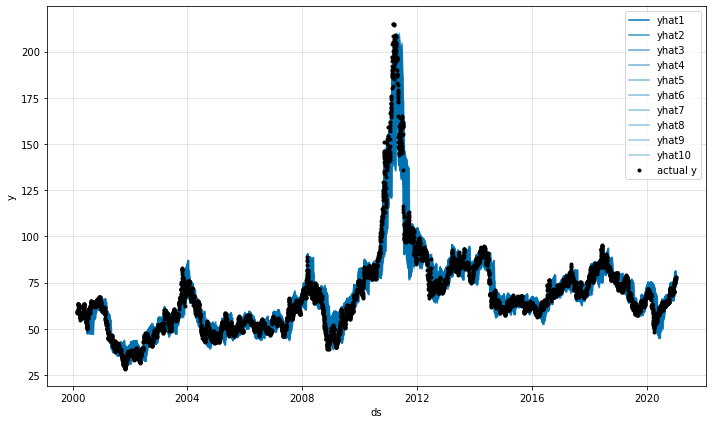

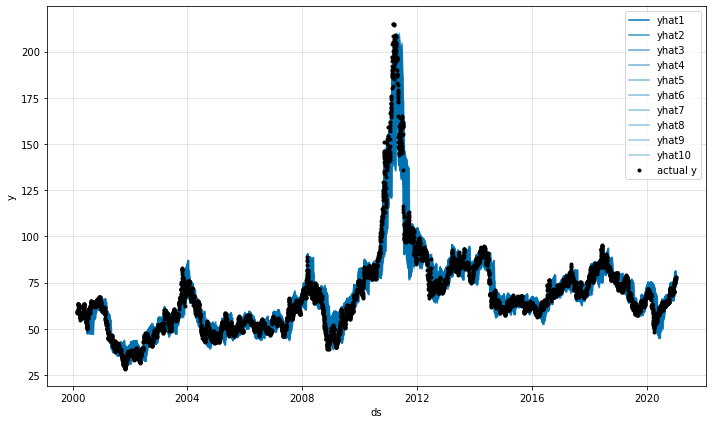

In [22]:
#BASE model to forecast for 60 days 

m = NeuralProphet(daily_seasonality=False, n_lags=100, n_forecasts=80,
                  n_changepoints=5, learning_rate=0.1,epochs=250, 
#                   optimizer="SDG"
#                   num_hidden_layer2=3,
                  batch_size=25, normalize='minmax')

metrics = m.fit(df_prophet, freq='D')
predicted = m.predict(df_prophet)
m.plot(predicted)

INFO - (NP.forecaster._handle_missing_data) - 117 missing dates added.
INFO - (NP.forecaster._handle_missing_data) - 117 NaN values in column y were auto-imputed.
WARNING - (py.warnings._showwarnmsg) - /opt/conda/lib/python3.8/site-packages/torch/nn/modules/container.py:552: UserWarning: Setting attributes on ParameterDict is not supported.
  warnings.warn("Setting attributes on ParameterDict is not supported.")

WARNING - (NP.plotting.plot) - Legend is available only for the ten first handles


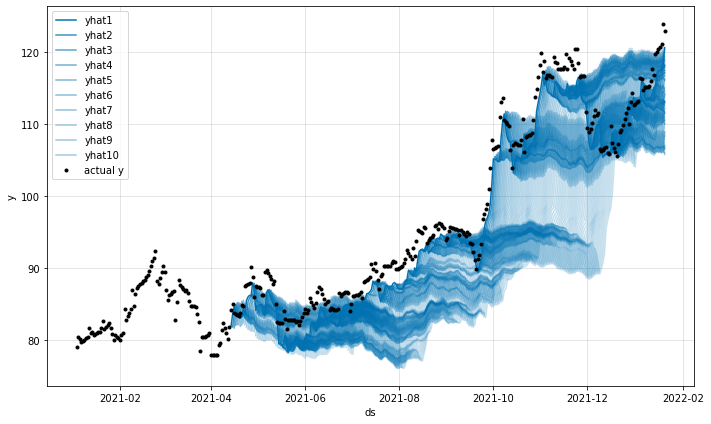

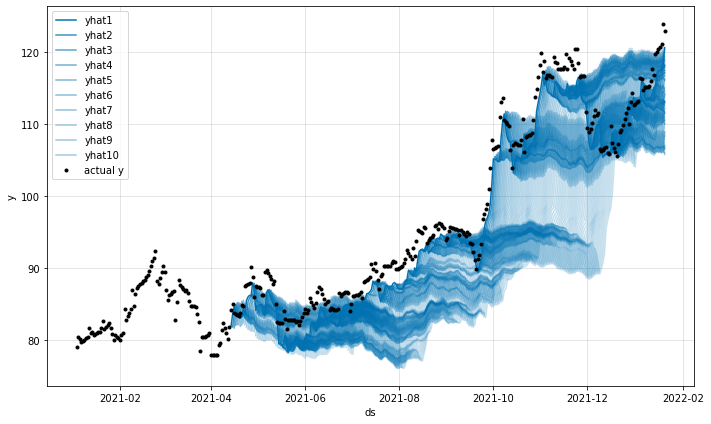

In [23]:
#Need min n_lag row of test data
predicted_test = m.predict(test_df1)
m.plot(predicted_test)
# plt.legend(fontsize=10)

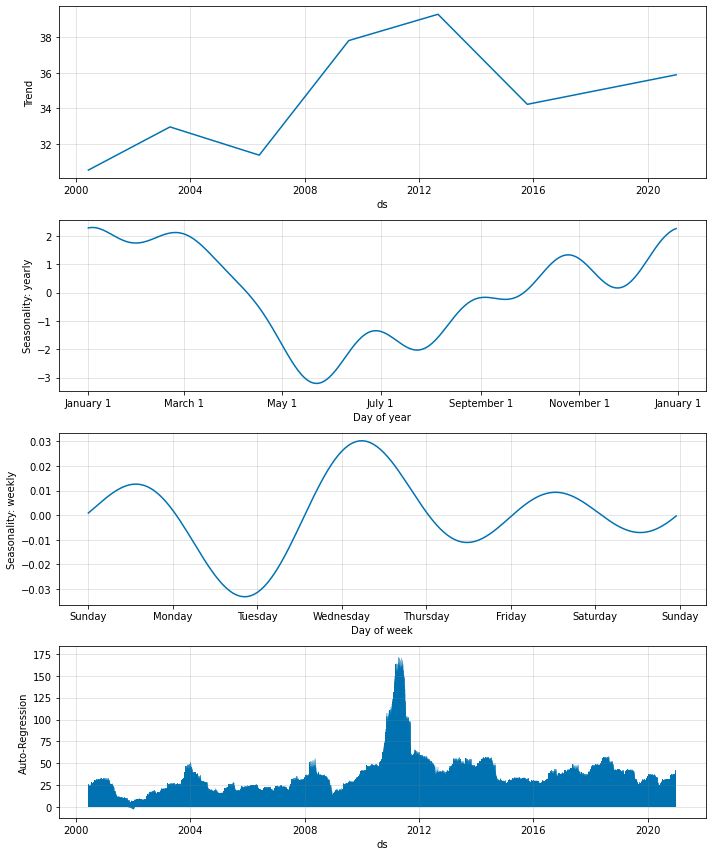

In [24]:
fig_comp = m.plot_components(predicted)

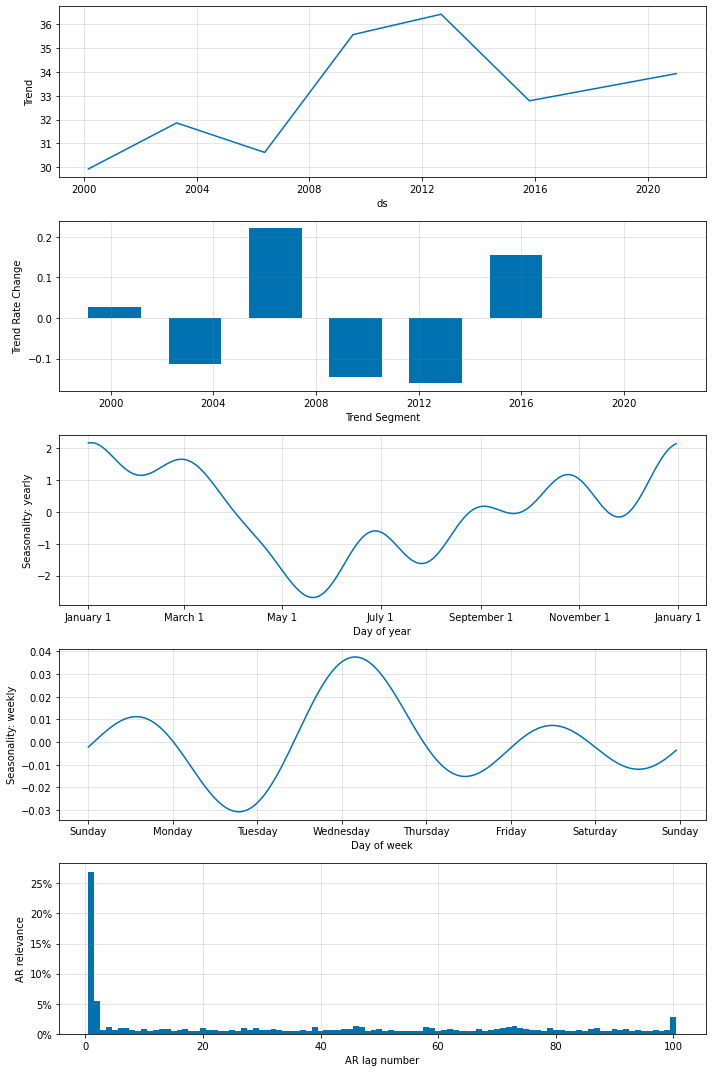

In [55]:
fig_param = m.plot_parameters()

INFO - (NP.forecaster._handle_missing_data) - 117 missing dates added.
INFO - (NP.forecaster._handle_missing_data) - 117 NaN values in column y were auto-imputed.
WARNING - (py.warnings._showwarnmsg) - /opt/conda/lib/python3.8/site-packages/torch/nn/modules/container.py:552: UserWarning: Setting attributes on ParameterDict is not supported.
  warnings.warn("Setting attributes on ParameterDict is not supported.")

WARNING - (NP.plotting.plot) - Legend is available only for the ten first handles


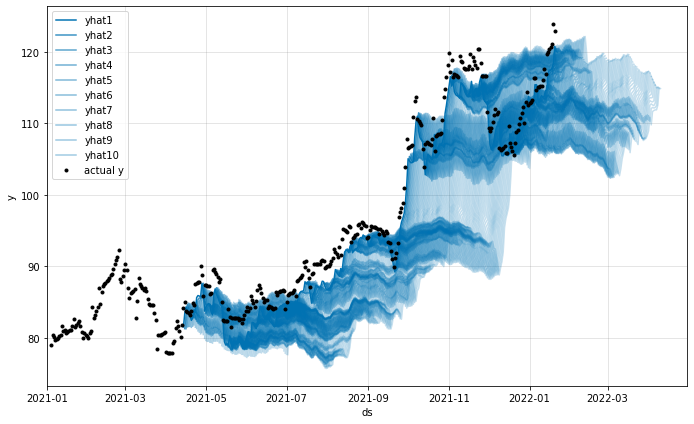

In [31]:
left = datetime.date(2021, 1, 1)
right = datetime.date(2022, 4, 30)
future = m.make_future_dataframe(test_df1, periods=80, n_historic_predictions=True)
forecast = m.predict(future)
m.plot(forecast)
plt.gca().set_xbound(left,right)

WARNING - (NP.plotting.plot) - Legend is available only for the ten first handles


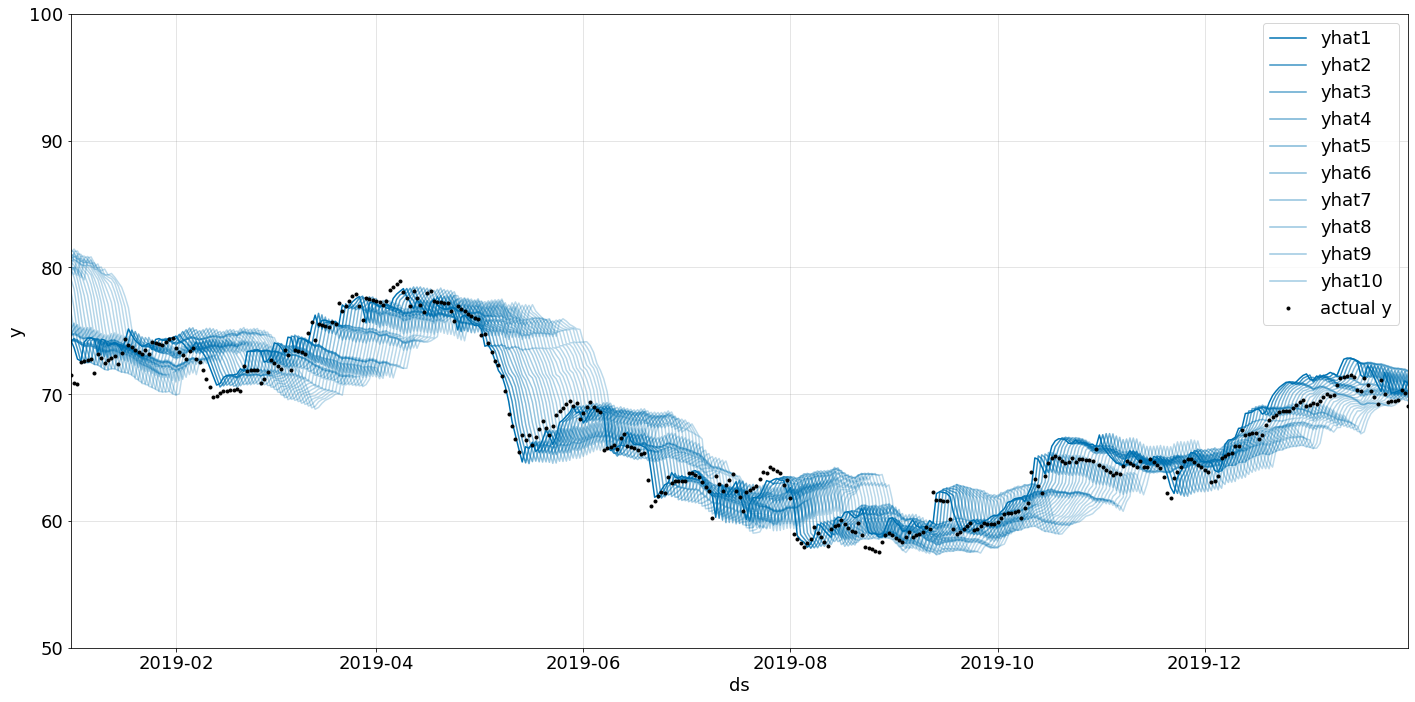

In [71]:
# Not used, only for full date model
left = datetime.date(2019, 1, 1)
right = datetime.date(2020, 1, 30)


m.plot(predicted, figsize=(20,10))
plt.gca().set_xbound(left,right)
plt.gca().set_ybound(50,100)

WARNING - (NP.plotting.plot) - Legend is available only for the ten first handles


[]

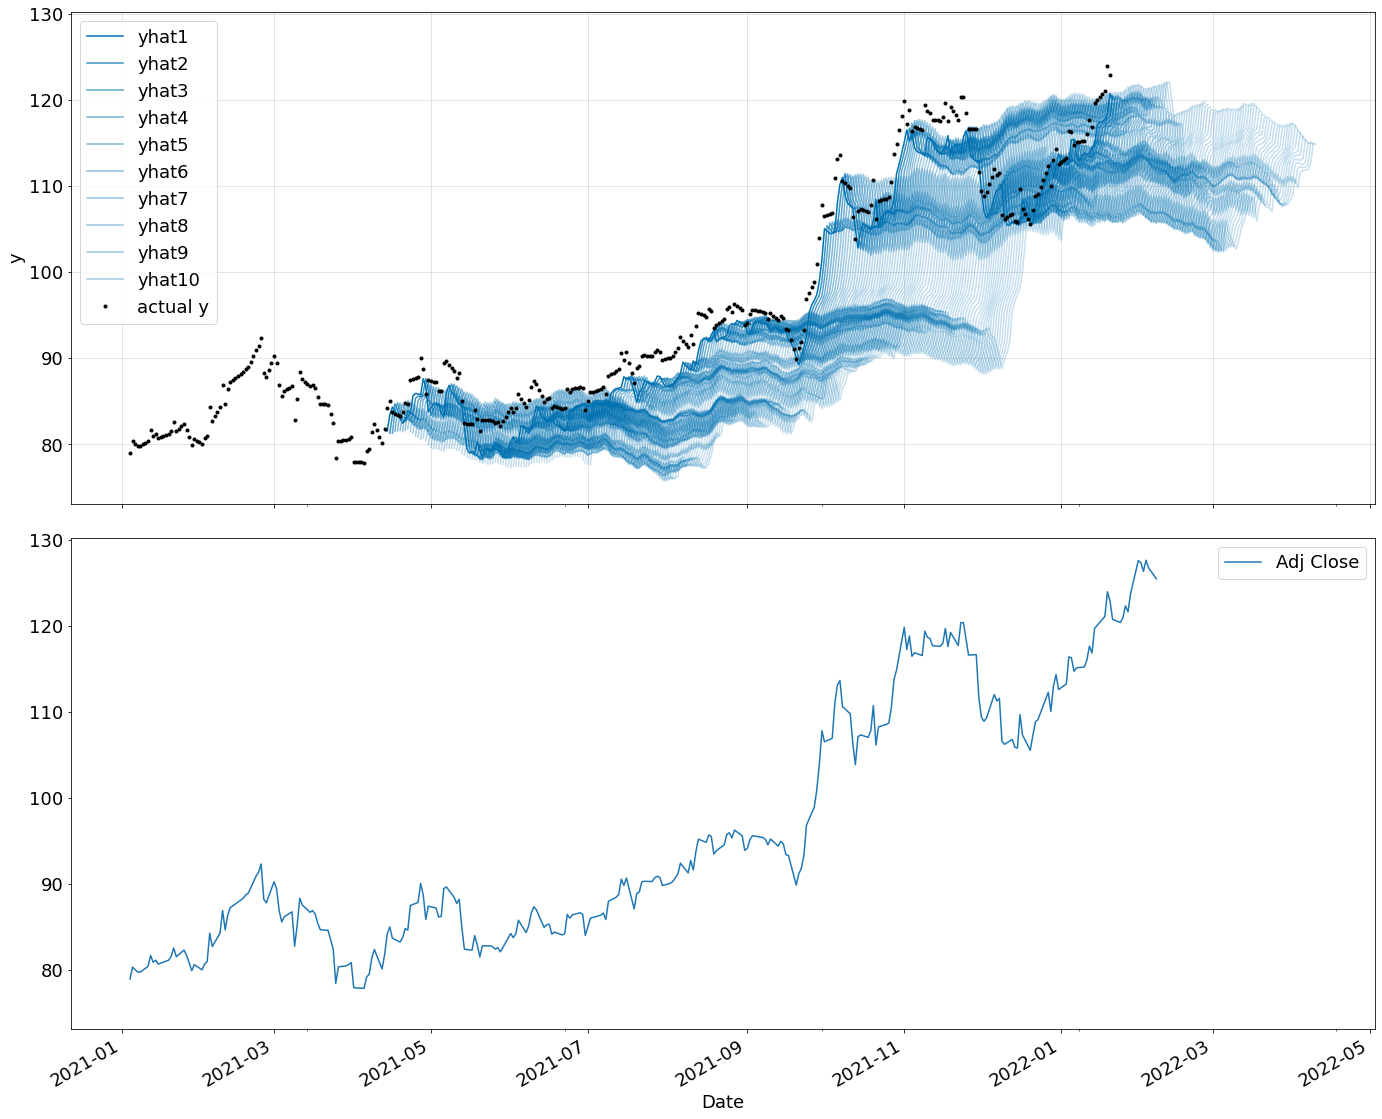

In [32]:
left = datetime.date(2021, 1, 1)
right = datetime.date(2022, 3, 30)
plt.rcParams.update({'font.size': 18})
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(20, 18),sharex=True,sharey=True)

m.plot(forecast,ax=axes[0])
plt.gca().set_xbound(left,right)
test_df_plot.plot(ax=axes[1])


plt.plot()